In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
amp_file = '/Users/bogao/DataFiles/Data/feature/feature_amp_genes.tsv'
del_file = '/Users/bogao/DataFiles/Data/feature/feature_del_genes.tsv'

damp = pd.read_csv(amp_file, sep='\t')
ddel = pd.read_csv(del_file, sep='\t')

## amp merge

In [4]:
damp['start_n'] = damp['start'].shift(-1)
damp['end_p'] = damp['end'].shift(1)

damp['chr_n'] = damp['chr'].shift(-1)
damp['chr_p'] = damp['chr'].shift(1)

damp = damp.fillna(0)

damp['head_gap'] = damp['start'] - damp['end_p']
damp['tail_gap'] = damp['start_n'] - damp['end']
damp['head_chr'] = np.abs(damp['chr'] - damp['chr_p'])
damp['tail_chr'] = np.abs(damp['chr'] - damp['chr_n'])

In [5]:
focals = []
marks = []
counter = 0
gap_thresh = 5e6

cur_chr = 1
for i in range(damp.shape[0]):
    if i == damp.shape[0]-1:
        damp.loc[i, 'tail_gap'] = gap_thresh + 1
    
    if damp.loc[i, 'chr'] > cur_chr:
        damp.loc[i, 'head_gap'] = gap_thresh + 1
        damp.loc[i-1, 'tail_gap'] = gap_thresh + 1
        cur_chr = damp.loc[i, 'chr']
    

In [6]:
for i in range(damp.shape[0]):
    
    if (damp.loc[i, 'head_gap'] > gap_thresh) and (damp.loc[i, 'tail_gap'] > gap_thresh):
        ## focal 
        focals.append(1)
        if (counter >0):
            counter += 1
        marks.append(counter)
    else:
        ## adjacent genes
        focals.append(0)
        
        if (damp.loc[i, 'head_chr'] == 0) and (focals[-2] == 0):
            ## same event
            marks.append(counter)
        else:
            ## different event
            counter += 1
            marks.append(counter)
    
damp['mark'] = marks
damp['focal'] = focals

In [7]:
merged = []
last_mark = 0
genes = []
chro, start, end = 0, 0, 0

for i in range(damp.shape[0]):
    if damp.loc[i, 'focal'] == 1:
        ## focal
        merged.append(damp.loc[i, ['gene_id','chr', 'start','end','focal' ]])
        last_mark = damp.loc[i, 'mark']
    else:
        if last_mark != damp.loc[i, 'mark']:
            ## start
            gene, chro, start, end = damp.loc[i, ['gene_id','chr', 'start', 'end']]
            genes.append(gene)
        else:
            ## continue
            gene, end = damp.loc[i, ['gene_id', 'end']]
            genes.append(gene)
        last_mark = damp.loc[i, 'mark']
        
        if i+1 == damp.shape[0] or damp.loc[i+1, 'mark'] > damp.loc[i, 'mark']:
            ## last one
            merged.append([genes, chro, start, end, 0 ])
            genes = []
        

In [8]:
dm = pd.DataFrame(np.array(merged), columns=['genes', 'chr', 'start', 'end', 'focal'])

/Users/bogao/anaconda3/envs/plot/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [9]:
dm['centre'] = np.ceil(dm['start']+dm['end'])
dm['size'] = dm['end'] - dm['start']
dm['Size (mb):'] = np.ceil(dm['size']/1000000)
dm['Type:'] = dm['focal'].map({0:'Regional',1:'Focal'})
dm['CNV:'] = 'Amp'

## del merge

In [10]:
ddel['start_n'] = ddel['start'].shift(-1)
ddel['end_p'] = ddel['end'].shift(1)

ddel['chr_n'] = ddel['chr'].shift(-1)
ddel['chr_p'] = ddel['chr'].shift(1)

ddel = ddel.fillna(0)

ddel['head_gap'] = ddel['start'] - ddel['end_p']
ddel['tail_gap'] = ddel['start_n'] - ddel['end']
ddel['head_chr'] = np.abs(ddel['chr'] - ddel['chr_p'])
ddel['tail_chr'] = np.abs(ddel['chr'] - ddel['chr_n'])

focals = []
marks = []
counter = 0
gap_thresh = 5e6

cur_chr = 1
for i in range(ddel.shape[0]):
    if i == ddel.shape[0]-1:
        ddel.loc[i, 'tail_gap'] = gap_thresh + 1
    
    if ddel.loc[i, 'chr'] > cur_chr:
        ddel.loc[i, 'head_gap'] = gap_thresh + 1
        ddel.loc[i-1, 'tail_gap'] = gap_thresh + 1
        cur_chr = ddel.loc[i, 'chr'] 
    

for i in range(ddel.shape[0]):
    
    if (ddel.loc[i, 'head_gap'] > gap_thresh) and (ddel.loc[i, 'tail_gap'] > gap_thresh):
        ## focal 
        focals.append(1)
        if (counter >0):
            counter += 1
        marks.append(counter)
    else:
        ## adjacent genes
        focals.append(0)
        
        if (ddel.loc[i, 'head_chr'] == 0) and (focals[-2] == 0):
            ## same event
            marks.append(counter)
        else:
            ## different event
            counter += 1
            marks.append(counter)
    
ddel['mark'] = marks
ddel['focal'] = focals

merged_d = []
last_mark = 0
genes = []
chro, start, end = 0, 0, 0

for i in range(ddel.shape[0]):
    if ddel.loc[i, 'focal'] == 1:
        ## focal
        merged_d.append(ddel.loc[i, ['gene_id','chr', 'start','end','focal' ]])
        last_mark = ddel.loc[i, 'mark']
    else:
        if last_mark != ddel.loc[i, 'mark']:
            ## start
            gene, chro, start, end = ddel.loc[i, ['gene_id','chr', 'start', 'end']]
            genes.append(gene)
        else:
            ## continue
            gene, end = ddel.loc[i, ['gene_id', 'end']]
            genes.append(gene)
        last_mark = ddel.loc[i, 'mark']
        
        if i+1 == ddel.shape[0] or ddel.loc[i+1, 'mark'] > ddel.loc[i, 'mark']:
            ## last one
            merged_d.append([genes, chro, start, end, 0 ])
            genes = []
        

In [11]:
dm_d = pd.DataFrame(np.array(merged_d), columns=['genes', 'chr', 'start', 'end', 'focal'])

/Users/bogao/anaconda3/envs/plot/lib/python3.6/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.


In [12]:
dm_d['centre'] = np.ceil(dm_d['start']+dm_d['end'])
dm_d['size'] = dm_d['end'] - dm_d['start']
dm_d['Size (mb):'] = np.ceil(dm_d['size']/1000000)
dm_d['Type:'] = dm_d['focal'].map({0:'Regional',1:'Focal'})
dm_d['CNV:'] = 'Del'

## scatter plot

In [13]:
dm_comb = pd.concat([dm,dm_d])

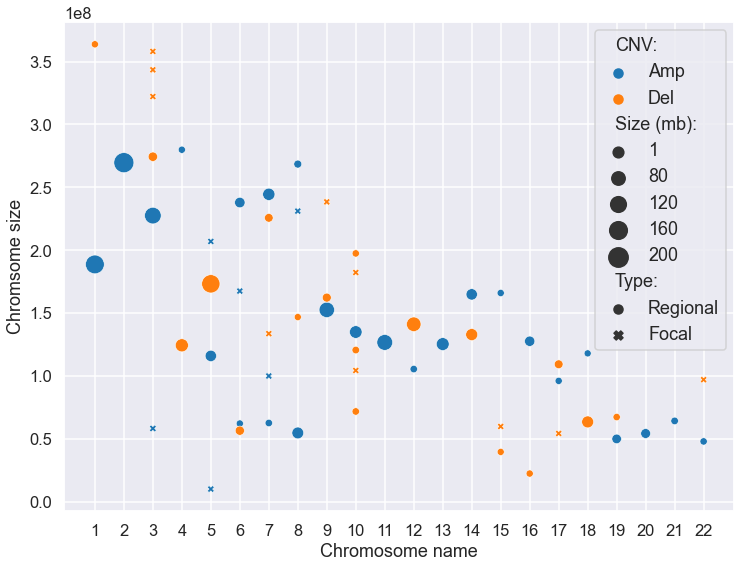

In [15]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(12,9))
g = sns.scatterplot(data=dm_comb, x='chr', y='centre', hue='CNV:', style='Type:',size='Size (mb):', sizes=(50,400),  markers=('o','X'))
g.set_xticks(range(1,23))
g.set(xlabel='Chromosome name', ylabel='Chromsome size')
g.legend_.texts[4].set_text('1')
plt.savefig('/Users/bogao/DataFiles/plots/newlandscape/new/focal_regional_scatter.pdf',bbox_inches='tight')

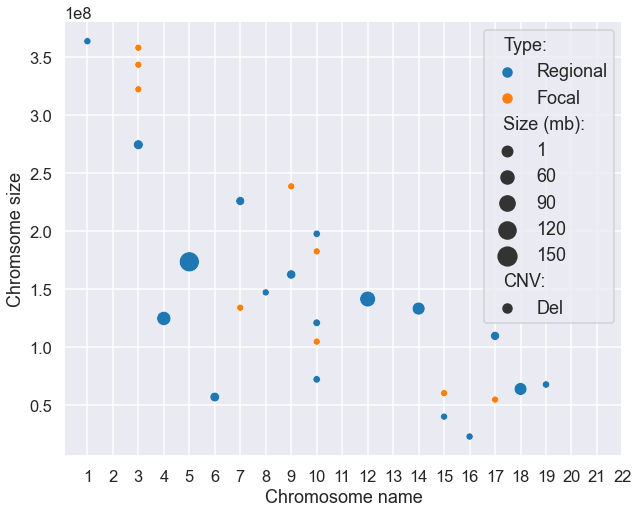

In [17]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
g = sns.scatterplot(data=dm_d, x='chr', y='centre', hue='Type:', size='Size (mb):', sizes=(50,400), style='CNV:')
g.set_xticks(range(1,23))
g.set(xlabel='Chromosome name', ylabel='Chromsome size')
g.legend_.texts[4].set_text('1')

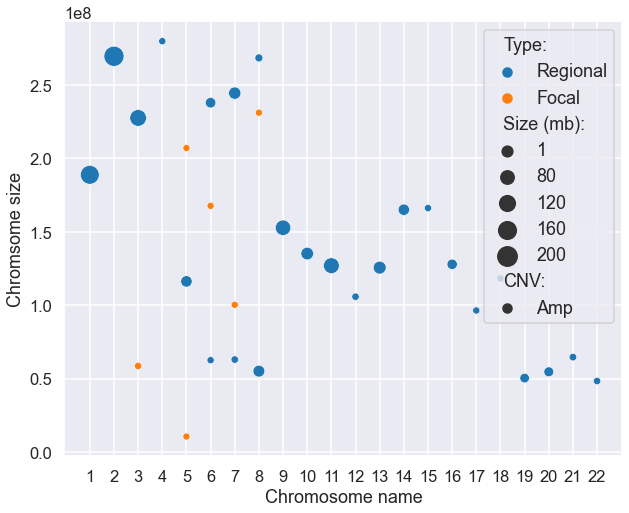

In [46]:
sns.set_context('talk')
sns.set_style('darkgrid')
plt.figure(figsize=(10,8))
g = sns.scatterplot(data=dm, x='chr', y='centre', hue='Type:', size='Size (mb):', sizes=(50,400), style='CNV:')
g.set_xticks(range(1,23))
g.set(xlabel='Chromosome name', ylabel='Chromsome size')
g.legend_.texts[4].set_text('1')


## hist plot

In [16]:
dm_comb['Type: '] = dm_comb['CNV:']

In [17]:
dm_comb.loc[dm_comb['focal'] ==1,'Type: '] = 'Focal'

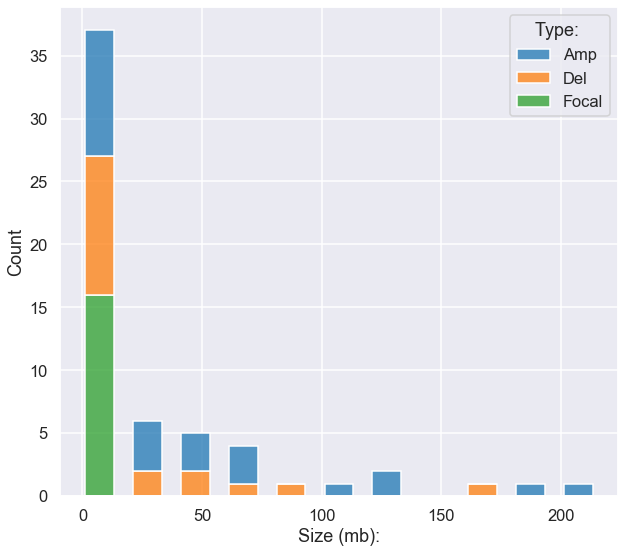

In [18]:

plt.figure(figsize=(10,9))
sns.histplot(data=dm_comb, x='Size (mb):', hue='Type: ', multiple='stack', binwidth=20, hue_order=('Amp','Del','Focal'), shrink=0.6)
plt.savefig('/Users/bogao/DataFiles/plots/newlandscape/new/focal_regional_hist.pdf',bbox_inches='tight')

In [123]:
dm_comb

,genes,chr,start,end,focal,centre,size,Size (mb):,Type:,CNV:,Type:
0,"[ENSG00000157911, ENSG00000157873, ENSG0000015...",1,2403964,186461114,0,188865078,184057150,185,Regional,Amp,Amp
1,"[ENSG00000243147, ENSG00000213639, ENSG0000017...",2,27771717,241902551,0,269674268,214130834,215,Regional,Amp,Amp
2,[ENSG00000144642],3,28574791,30010391,1,58585182,1435600,2,Focal,Amp,Focal
3,"[ENSG00000196653, ENSG00000249992, ENSG0000001...",3,44712643,182921629,0,227634272,138208986,139,Regional,Amp,Amp
4,"[ENSG00000172007, ENSG00000153132, ENSG0000020...",4,139453232,140498377,0,279951609,1045145,2,Regional,Amp,Amp
5,[ENSG00000145536],5,5140330,5320304,1,10460634,179974,1,Focal,Amp,Focal
6,"[ENSG00000182631, ENSG00000164175, ENSG0000024...",5,33936386,82276857,0,116213243,48340471,49,Regional,Amp,Amp
7,[ENSG00000112874],5,103548855,103562790,1,207111645,13935,1,Focal,Amp,Focal
8,"[ENSG00000204590, ENSG00000204569, ENSG0000013...",6,30541377,31972290,0,62513667,1430913,2,Regional,Amp,Amp
9,[ENSG00000203877],6,83853266,83857515,1,167710781,4249,1,Focal,Amp,Focal


## quantification

In [19]:
import pickle
import os
from scipy import stats

### disease name-code mapping

In [48]:
dislist =   {'Brain Astrocytoma':['94003', '94013'],
  'Brain Glioma':['93803', '94403'],
  'Brain Mixed glioma':['93823'],
  'Brain Oligodendroglioma':['94503', '94513'],
  'Brain Primitive neuroectodermal tumor':['94733'],
  
  'Breast Infiltrating duct carcinoma':['85003'],
  'Breast Intraductal carcinoma':['85002'],
  'Breast Lobular carcinoma':['85203'],
  
  'Cerebellum Medulloblastoma': ['94703','94713','94743'],
             
  'Colon Adenocarcinoma':['81403'],
  'Colon Adenocarcinoma intestinal type':['81443'],
  'Colon Adenoma':['81400'],
  'Colon Mucinous adenocarcinoma':['84803'],
  
  'Kidney Clear cell adenocarcinoma':['83103'],
  'Kidney Renal cell carcinoma':['83123', '83173'],
  
  'Liver Hepatocellular carcinoma':['81703'],
  
  'Lung Adenocarcinoma':['81403', '82553'],
  'Lung Carcinoma':['80103', '80123'],
  'Lung Non-small cell carcinoma':['80463'],
  'Lung Small cell carcinoma':['80413'],
  'Lung Squamous cell carcinoma':['80703'],
  
  'Ovary Adenocarcinoma':['81403', '83103', '83803'],
  'Ovary Carcinoma':['80103', '84413', '84421'],
  'Ovary Mucinous cystadenoma':['84700', '84800'],
  
  'Prostate Adenocarcinoma':['81403'],
  
  'Skin Melanoma':['87203', '87213', '87303'],
  
  'Stomach Adenocarcinoma':['81403'],
  'Stomach Adenocarcinoma intestinal type':['81443'],
  'Stomach Carcinoma diffuse type':['81453'],
  'Stomach Gastrointestinal stromal sarcoma':['89363'],
  'Stomach Tubular adenocarcinoma':['82113']}

In [49]:
distable = []
for k,v in dislist.items():
    for code in v:
        distable.append([k,code])

In [50]:
disease = pd.DataFrame(distable, columns=['name','code'])

In [51]:
disease_names = disease.name.unique()

### dm gene names: str->list

In [52]:
for index, row in dm_comb.iterrows():
    if type(row['genes']) == str:
        row['genes'] = [row['genes'] ]

### read in files

In [53]:
matfile = '/Users/bogao/DataFiles/new landscape/data/reduced_gene_mat.pkl'
labelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_disease_label.pkl'
with open(matfile,'rb') as fm, open(labelfile, 'rb') as fl:
    data = pickle.load(fm)
    labels = pickle.load(fl)

In [54]:
famp = pd.read_csv('/Users/bogao/DataFiles/Data/feature/feature_amp_genes.tsv', sep='\t')
fdel = pd.read_csv('/Users/bogao/DataFiles/Data/feature/feature_del_genes.tsv', sep='\t')
fgene = pd.concat([famp,fdel]).reset_index(drop=True)
number_amps = 750

In [55]:
for name in disease_names:
    codes = disease.loc[disease['name'] == name, 'code'].values
    mx = data[np.isin(labels, codes)]
    
    ## compute average signals
    ave_amp = np.mean(mx, axis=0)
    fgene[name] = ave_amp

In [56]:
fgene

,gene_id,name,chr,start,end,symbol,band,Brain Astrocytoma,Brain Glioma,Brain Mixed glioma,...,Ovary Adenocarcinoma,Ovary Carcinoma,Ovary Mucinous cystadenoma,Prostate Adenocarcinoma,Skin Melanoma,Stomach Adenocarcinoma,Stomach Adenocarcinoma intestinal type,Stomach Carcinoma diffuse type,Stomach Gastrointestinal stromal sarcoma,Stomach Tubular adenocarcinoma
0,ENSG00000157911,p36.32,1,2403964,2413797,PEX10,1p36.32,0.064517,0.105167,0.023031,...,0.094162,0.147330,0.030977,0.107348,0.197429,0.107348,0.024258,0.000000,0.046453,0.023647
1,ENSG00000157873,p36.32,1,2555639,2565382,TNFRSF14,1p36.32,0.064517,0.102591,0.023031,...,0.092421,0.149635,0.029121,0.105336,0.197400,0.105336,0.024258,0.000000,0.047773,0.023647
2,ENSG00000158109,p36.32,1,3625015,3630127,TPRG1L,1p36.32,0.083325,0.117750,0.023552,...,0.103774,0.185405,0.029121,0.116768,0.236511,0.116768,0.088920,0.073596,0.047773,0.103227
3,ENSG00000130764,p36.32,1,3778559,3796498,LRRC47,1p36.32,0.079465,0.112203,0.016430,...,0.101293,0.185201,0.029121,0.113412,0.203151,0.113412,0.089024,0.073596,0.047773,0.095733
4,ENSG00000169598,p36.32,1,3857267,3885429,DFFB,1p36.32,0.079261,0.108195,0.016430,...,0.086173,0.159417,0.029121,0.095481,0.196645,0.095481,0.088787,0.072544,0.041574,0.093743
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
922,ENSG00000153896,q13.11,19,34758073,34773229,ZNF599,19q13.11,-0.156027,-0.110683,-0.413581,...,-0.105855,-0.129700,-0.020916,-0.119576,-0.129464,-0.119576,-0.098599,-0.056323,-0.157439,-0.301386
923,ENSG00000180884,q13.11,19,34956354,34964229,ZNF792,19q13.11,-0.156027,-0.110234,-0.413581,...,-0.105127,-0.128968,-0.020916,-0.118693,-0.130377,-0.118693,-0.098599,-0.056323,-0.157439,-0.301386
924,ENSG00000089351,q13.11,19,34994784,35026471,GRAMD1A,19q13.11,-0.160694,-0.110807,-0.423773,...,-0.104555,-0.125843,-0.020916,-0.117989,-0.127710,-0.117989,-0.098599,-0.056323,-0.163940,-0.241575
925,ENSG00000105711,q13.11,19,35030470,35040449,SCN1B,19q13.11,-0.160694,-0.110751,-0.423773,...,-0.104478,-0.125808,-0.020916,-0.117895,-0.119681,-0.117895,-0.098599,-0.056323,-0.163940,-0.241575


In [57]:
values = []
for index, row in dm_comb.iterrows():
    valsum = []
    for geneid in row['genes']:
        val = fgene.loc[fgene['gene_id'] == geneid, disease_names].values[0]
#         print(geneid)
#         print(val)
        valsum.append(val)
    values.append(np.mean(valsum, axis=0))

In [58]:
dm_comb['heat_label'] = dm_comb['Type:'].str[:1] + '(' + dm_comb['chr'].astype(str) + ')'

In [59]:
sns.set_context('paper')

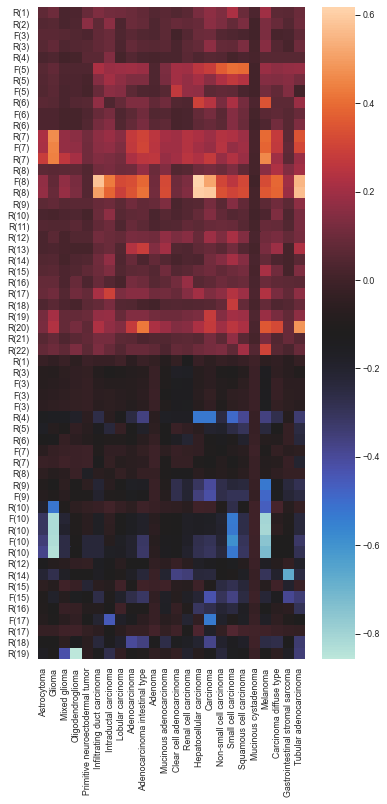

In [426]:
plt.figure(figsize=(6,12))
g = sns.heatmap(values, 

               cmap="icefire", 

               xticklabels=disease_names,
               yticklabels=dm_comb['heat_label'],
              )

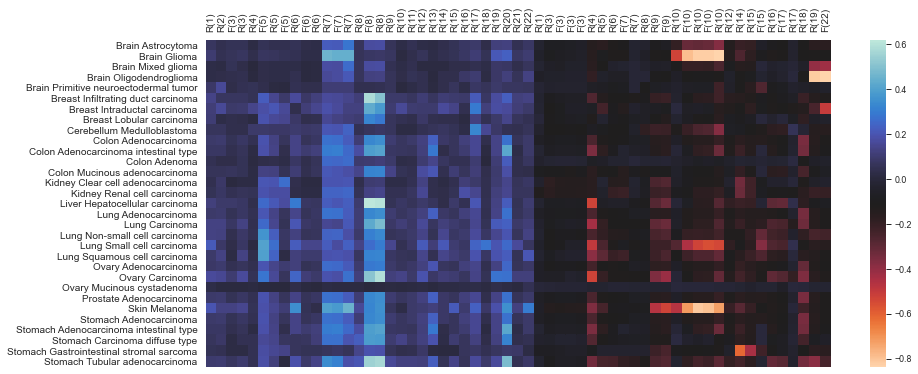

In [75]:
sns.set_context('paper')
plt.figure(figsize=(14,6))
plt.tick_params(axis='both', which='major', labelsize=10, labelbottom = False, bottom=False, top = False, labeltop=True)

g = sns.heatmap(np.transpose(values), 

               cmap="icefire_r", 

               yticklabels=disease_names,
               xticklabels=dm_comb['heat_label'],
              )
plt.savefig('/Users/bogao/DataFiles/plots/newlandscape/new/focal_regional_heat.pdf',bbox_inches='tight')

In [68]:
values = np.array(values)
np.mean(values[values>0])

0.12114587421247164

In [70]:
np.std(values[values>0])

0.09768742687777397

In [69]:
np.mean(values[values<0])

-0.13510386841065541

In [71]:
values.shape

(59, 31)

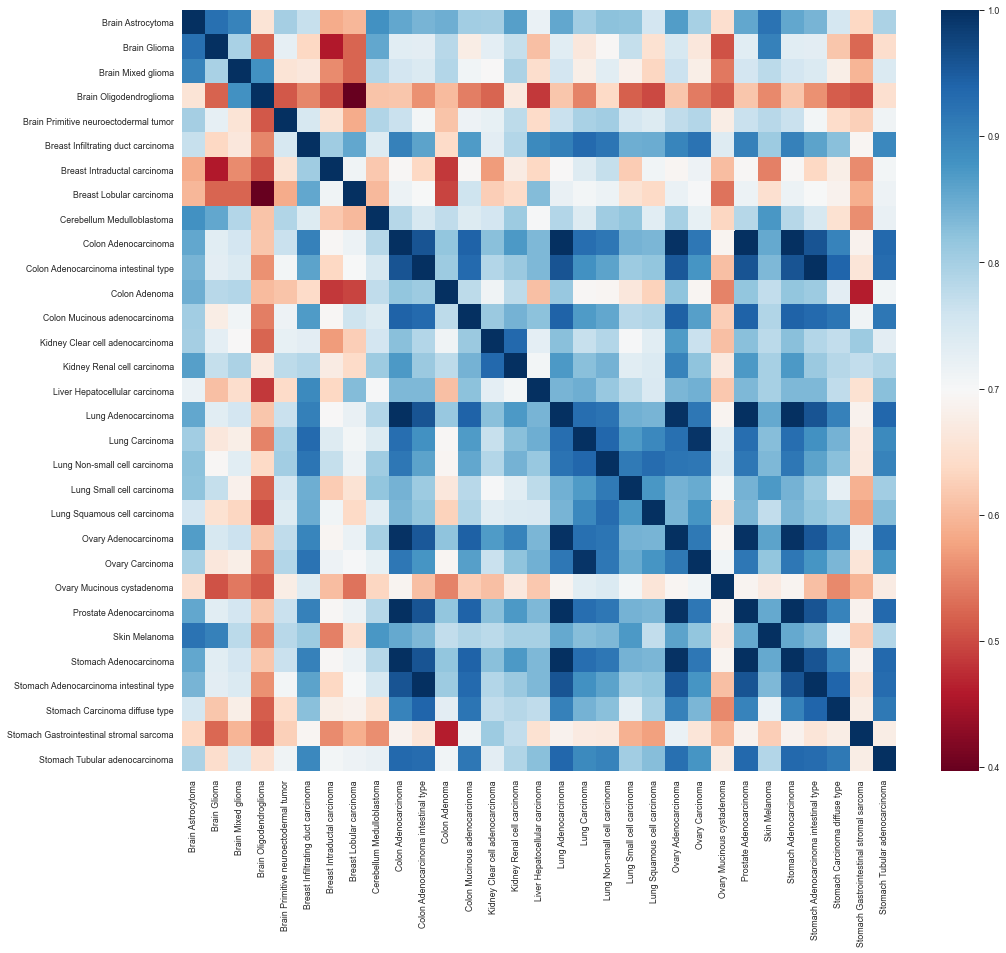

In [86]:
plt.figure(figsize=(16,14))
sns.heatmap(fgene.iloc[:,7:].corr(),
            cmap="RdBu",)

In [80]:
values.shape

(59, 31)